In [8]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from torch_geometric.loader import DataLoader
from MyDataset import MyDataset

%config InlineBackend.figure_format = 'png2x'
plt.rcParams['font.size'] = 8

## Get Boolean index

In [9]:
# Time steps
nt = 12

# All buses
num_buses = 118
buses = np.arange(1, num_buses+1)

# Read thermal buses
file_path = f'../../data/IEEE_Case118/zones/thermal_bus.csv'
thermal_buses = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
# Read load buses
file_path = f'../../data/IEEE_Case118/zones/load_bus.csv'
load_buses = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
# Read wind buses
file_path = f'../../data/IEEE_Case118/zones/wind_bus.csv'
wind_buses = pd.read_csv(file_path, header=None, index_col=None).to_numpy()

# Get wind bidx
wind_bidx = np.isin(buses, wind_buses)
# Get thermal buses Boolean index
thermal_bidx = np.isin(buses, thermal_buses)
# Get load buses Boolean index
load_bidx = np.isin(buses, load_buses)

## ANN

#### MRE of PG

In [3]:
# Overall number of PG
num_data = 200

# Record relative error
rela_err = np.zeros((num_data, thermal_bidx.sum(), nt))

for i in range(num_data):
    # Read PG true
    file_path = f'./model_evaluation/ANN/PG_true/true_{i+1}.csv'
    PG_true = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    PG_true = PG_true[thermal_bidx]
    PG_true = np.round(PG_true, 2)

    # Read PG prediction
    file_path = f'./model_evaluation/ANN/PG_pred/pred_{i+1}.csv'
    PG_pred = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    PG_pred = PG_pred[thermal_bidx]
    PG_pred = np.round(PG_pred, 2)

    # Calculate relative error
    indices = np.where(PG_true!=0) 
    rela_err[i][indices] = np.abs((PG_true[indices] - PG_pred[indices]) / PG_true[indices]) * 100

    indices = np.where((PG_true == 0) & (PG_pred == 0))
    rela_err[i][indices] = 0.

    indices = np.where((PG_true == 0) & (PG_pred != 0))
    rela_err[i][indices] = np.NaN

# Don't count the case where the relative error is inf
mre = np.nanmean(rela_err, axis=0)

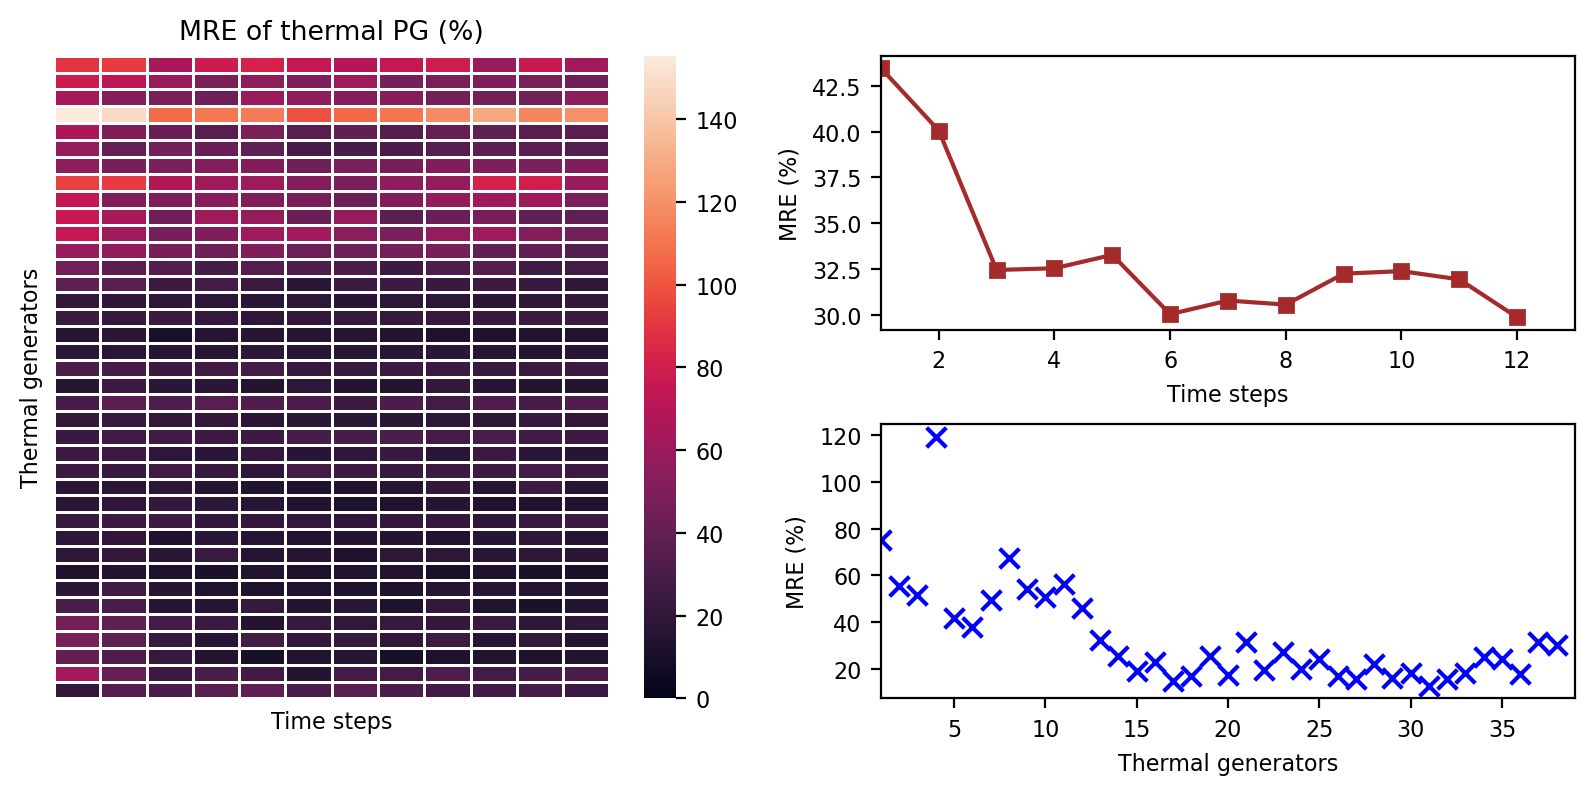

In [4]:
# Plot mean relative error
fig = plt.figure(figsize=(8, 4))
gs = GridSpec(2, 2)

ax = plt.subplot(gs[:, 0])
sns.heatmap(mre, 
            ax=ax,
            vmin=0,
            # vmax=100,
            xticklabels=[],
            yticklabels=[],
            linewidth=0.5)
ax.set_title('MRE of thermal PG (%)')
ax.set_xlabel('Time steps')
ax.set_ylabel('Thermal generators')

x = np.arange(1, 13)
mre_avg = mre.mean(axis=0)
ax = plt.subplot(gs[0, 1])
ax.plot(x, mre_avg, marker='s', color='brown', markersize=5)
ax.set_xlim((1, 13))
# ax.set_ylim((0, 10))
ax.set_xlabel('Time steps')
ax.set_ylabel('MRE (%)')

x = np.arange(1, 39)
mre_avg = mre.mean(axis=1)
ax = plt.subplot(gs[1, 1])
ax.scatter(x, mre_avg, marker='x', color='blue', s=50)
ax.set_xlim((1, 39))
ax.set_xlabel('Thermal generators')
ax.set_ylabel('MRE (%)')

plt.tight_layout()
plt.show()
plt.close('all')

##### MRE of aggregated PG

In [5]:
# Buses in each zone
file_path = '../../data/IEEE_Case118/zones/zone1_bus.csv'
zone1_buses = pd.read_csv(file_path, header=None, index_col=None).to_numpy()

file_path = '../../data/IEEE_Case118/zones/zone2_bus.csv'
zone2_buses = pd.read_csv(file_path, header=None, index_col=None).to_numpy()

file_path = '../../data/IEEE_Case118/zones/zone3_bus.csv'
zone3_buses = pd.read_csv(file_path, header=None, index_col=None).to_numpy()

# Thermal bidx in each zone
thermal_bidx_zone1 = np.isin(thermal_buses, zone1_buses).flatten()
thermal_bidx_zone2 = np.isin(thermal_buses, zone2_buses).flatten()
thermal_bidx_zone3 = np.isin(thermal_buses, zone3_buses).flatten()

In [6]:
# Number of zones
num_zones = 3

# PG sum
PG_sum_true = np.zeros((num_data, num_zones+1, nt))
PG_sum_pred = np.zeros((num_data, num_zones+1, nt))

for i in range(num_data):
    # Read PG true
    file_path = f'./model_evaluation/ANN/PG_true/true_{i+1}.csv'
    PG_true = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    PG_true = PG_true[thermal_bidx, :nt]
    PG_true = np.round(PG_true, 2)
    temp0 = PG_true[thermal_bidx_zone1].sum(axis=0)
    temp1 = PG_true[thermal_bidx_zone2].sum(axis=0)
    temp2 = PG_true[thermal_bidx_zone3].sum(axis=0)
    temp3 = PG_true.sum(axis=0)
    PG_sum_true[i, 0] = temp0.copy()
    PG_sum_true[i, 1] = temp1.copy()
    PG_sum_true[i, 2] = temp2.copy()
    PG_sum_true[i, 3] = temp3.copy()

    # Read PG prediction
    file_path = f'./model_evaluation/ANN/PG_pred/pred_{i+1}.csv'
    PG_pred = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    PG_pred = PG_pred[thermal_bidx]
    PG_pred = np.round(PG_pred, 2)
    temp0 = PG_pred[thermal_bidx_zone1].sum(axis=0)
    temp1 = PG_pred[thermal_bidx_zone2].sum(axis=0)
    temp2 = PG_pred[thermal_bidx_zone3].sum(axis=0)
    temp3 = PG_pred.sum(axis=0)
    PG_sum_pred[i, 0] = temp0.copy()
    PG_sum_pred[i, 1] = temp1.copy()
    PG_sum_pred[i, 2] = temp2.copy()
    PG_sum_pred[i, 3] = temp3.copy()

# Calculate relative error
rela_err = np.abs((PG_sum_true - PG_sum_pred) / PG_sum_true) * 100

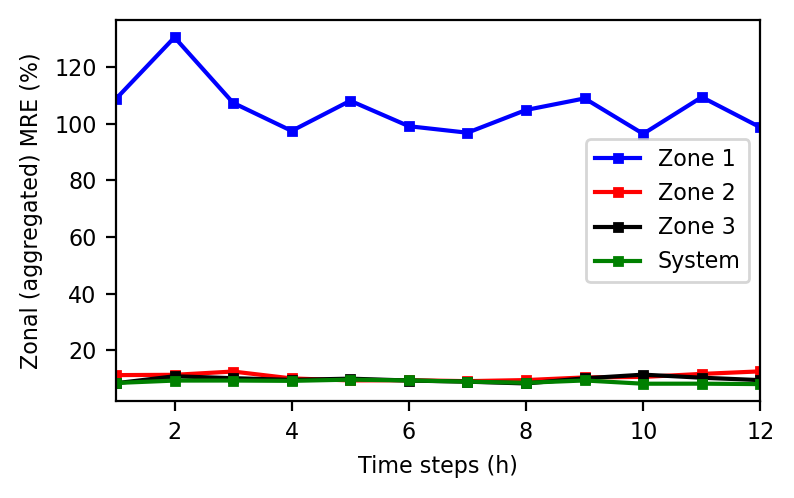

In [7]:
# Plot mean zonal aggregated PG relative error
fig = plt.figure(figsize=(4, 2.5))
ax = fig.add_subplot(1, 1, 1)
# Zone 1 aggregated PG
ax.plot(np.arange(12)+1, rela_err.mean(axis=0)[0], color='blue', marker='s', markersize=3, label='Zone 1')
# Zone 1 aggregated PG
ax.plot(np.arange(12)+1, rela_err.mean(axis=0)[1], color='red', marker='s', markersize=3, label='Zone 2')
# Zone 1 aggregated PG
ax.plot(np.arange(12)+1, rela_err.mean(axis=0)[2], color='black', marker='s', markersize=3, label='Zone 3')
# System aggregated PG
ax.plot(np.arange(12)+1, rela_err.mean(axis=0)[3], color='green', marker='s', markersize=3, label='System')

ax.set_xlim((1, 12))
# ax.set_ylim((0, 6))
ax.set_xlabel('Time steps (h)')
ax.set_ylabel('Zonal (aggregated) MRE (%)')
ax.legend()

plt.tight_layout()
plt.show()
plt.close('all')

##### MRE of DL

In [8]:
# Overall number of DL
num_data = 200

# Record relative error
rela_err = np.zeros((num_data, load_bidx.sum(), nt))

for i in range(num_data):
    # Read DL true
    file_path = f'./model_evaluation/ANN/DL_true/true_{i+1}.csv'
    DL_true = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    DL_true = DL_true[load_bidx]
    DL_true = np.round(DL_true, 2)

    # Read DL prediction
    file_path = f'./model_evaluation/ANN/DL_pred/pred_{i+1}.csv'
    DL_pred = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    DL_pred = DL_pred[load_bidx]
    DL_pred = np.round(DL_pred, 2)
    
    # Calculate relative error
    indices = np.where(DL_true!=0) 
    rela_err[i][indices] = np.abs((DL_true[indices] - DL_pred[indices]) / DL_true[indices]) * 100

    indices = np.where((DL_true == 0) & (DL_pred == 0))
    rela_err[i][indices] = 0.

    indices = np.where((DL_true == 0) & (DL_pred != 0))
    rela_err[i][indices] = np.NaN

# Don't count the case where the relative error is inf
mre = np.nanmean(rela_err, axis=0)

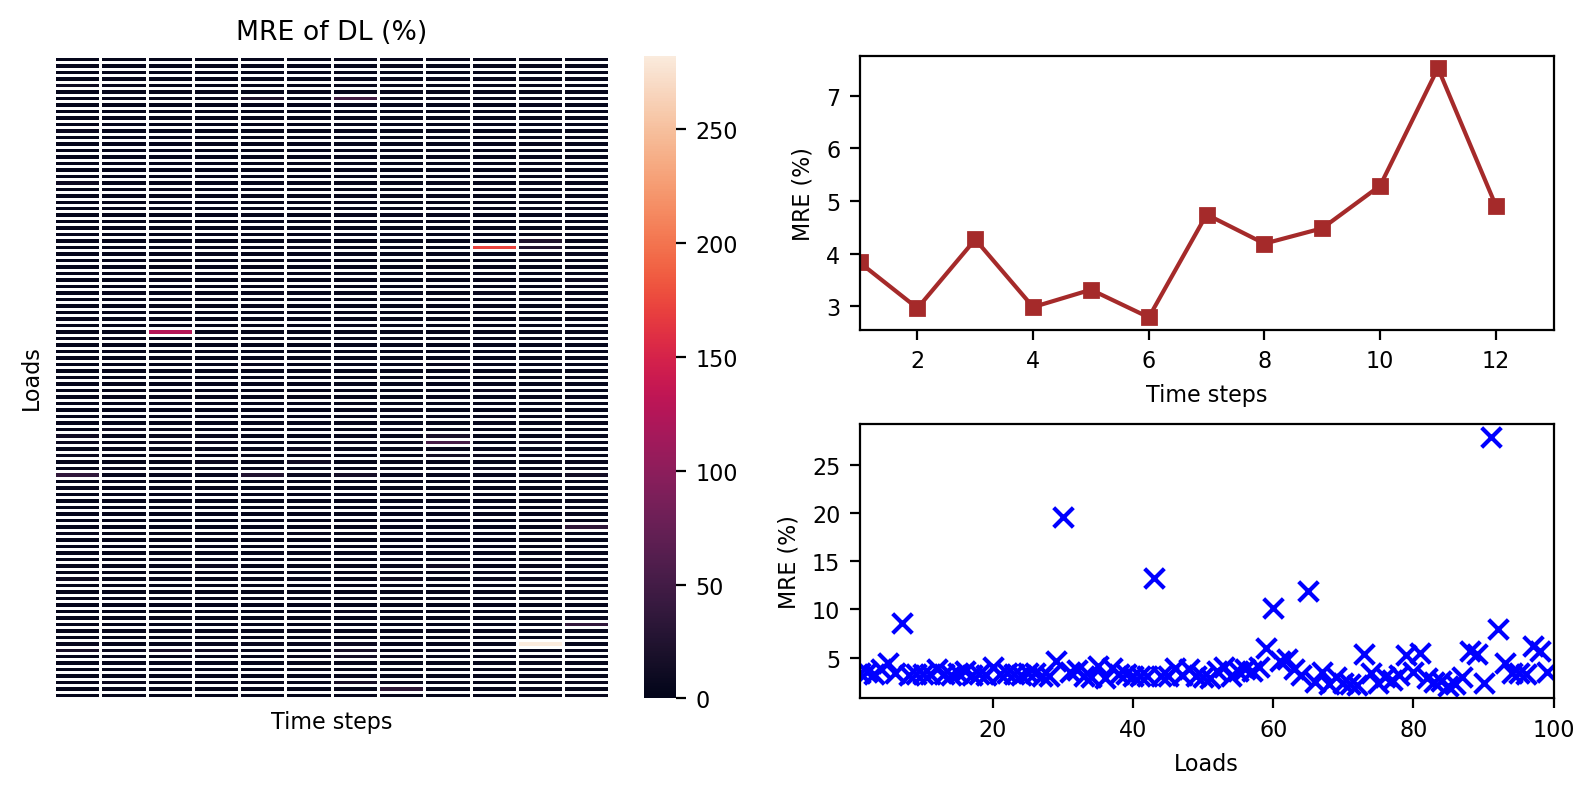

In [9]:
# Plot mean relative error
fig = plt.figure(figsize=(8, 4))
gs = GridSpec(2, 2)

ax = plt.subplot(gs[:, 0])
sns.heatmap(mre, 
            ax=ax,
            vmin=0,
            xticklabels=[],
            yticklabels=[],
            linewidth=0.5)
ax.set_title('MRE of DL (%)')
ax.set_xlabel('Time steps')
ax.set_ylabel('Loads')

x = np.arange(1, 13)
mre_avg = mre.mean(axis=0)
ax = plt.subplot(gs[0, 1])
ax.plot(x, mre_avg, marker='s', color='brown', markersize=5)
ax.set_xlim((1, 13))
ax.set_xlabel('Time steps')
ax.set_ylabel('MRE (%)')

x = np.arange(1, load_bidx.sum()+1)
mre_avg = mre.mean(axis=1)
ax = plt.subplot(gs[1, 1])
ax.scatter(x, mre_avg, marker='x', color='blue', s=50)
ax.set_xlim((1, load_bidx.sum()+1))
ax.set_xlabel('Loads')
ax.set_ylabel('MRE (%)')

plt.tight_layout()
plt.show()
plt.close('all')

#### Load shedding

In [10]:
# Root
root = '../../train_val_test_dataset/IEEE_Case118/DL-ANN'

# Load all data with empty input
dataset = MyDataset(root=root, data_list=[])

# Get train dataset
test_size = 200

test_dataset = dataset[-test_size:]

# Create train loader
############ Shuffle cannot be true for testing data ##############
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [11]:
# Load bidx in each zone
load_bidx_zone1 = np.isin(load_buses, zone1_buses).flatten()
load_bidx_zone2 = np.isin(load_buses, zone2_buses).flatten()
load_bidx_zone3 = np.isin(load_buses, zone3_buses).flatten()

In [12]:
# Get load inputs
load_input = np.zeros((num_data, num_zones+1, nt))

for i, loader in enumerate(test_loader):
    # Get load input of individual graph
    temp = loader.x.detach().numpy()[load_bidx, -nt:]
    load_input[i, 0] = temp[load_bidx_zone1].sum(axis=0)
    load_input[i, 1] = temp[load_bidx_zone2].sum(axis=0)
    load_input[i, 2] = temp[load_bidx_zone3].sum(axis=0)
    load_input[i, 3] = temp.sum(axis=0)

# Read DL ground truth and prediction
DL_true= np.zeros((num_data, num_zones+1, nt))
DL_pred = np.zeros((num_data, num_zones+1, nt))
for i in range(num_data):
    file_path = f'model_evaluation/ANN/DL_true/true_{i+1}.csv'
    temp = pd.read_csv(file_path, header=None, index_col=None).to_numpy()[load_bidx]
    # temp = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    DL_true[i, 0] = temp[load_bidx_zone1].sum(axis=0)
    DL_true[i, 1] = temp[load_bidx_zone2].sum(axis=0)
    DL_true[i, 2] = temp[load_bidx_zone3].sum(axis=0)
    DL_true[i, 3] = temp.sum(axis=0)

    file_path = f'model_evaluation/ANN/DL_pred/pred_{i+1}.csv'
    temp = pd.read_csv(file_path, header=None, index_col=None).to_numpy()[load_bidx]
    # temp = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    DL_pred[i, 0] = temp[load_bidx_zone1].sum(axis=0)
    DL_pred[i, 1] = temp[load_bidx_zone2].sum(axis=0)
    DL_pred[i, 2] = temp[load_bidx_zone3].sum(axis=0)
    DL_pred[i, 3] = temp.sum(axis=0)

In [13]:
# Calculate shedding
shedding_true = load_input - DL_true
shedding_pred = load_input - DL_pred

shedding_rela_err = np.zeros(shedding_true.shape)

# Set relative error = NaN for zero ground truth
indices = np.where(np.abs(shedding_true) <= 0)
shedding_rela_err[indices] = np.NaN

# Calculate relative error for nonzero ground truth
indices = np.where(np.abs(shedding_true) > 200)
shedding_rela_err[indices] = np.abs((shedding_true[indices] - shedding_pred[indices]) / shedding_true[indices]) * 100

# Calculate MRE of load shedding
shedding_mre = np.nanmean(shedding_rela_err, axis=0)

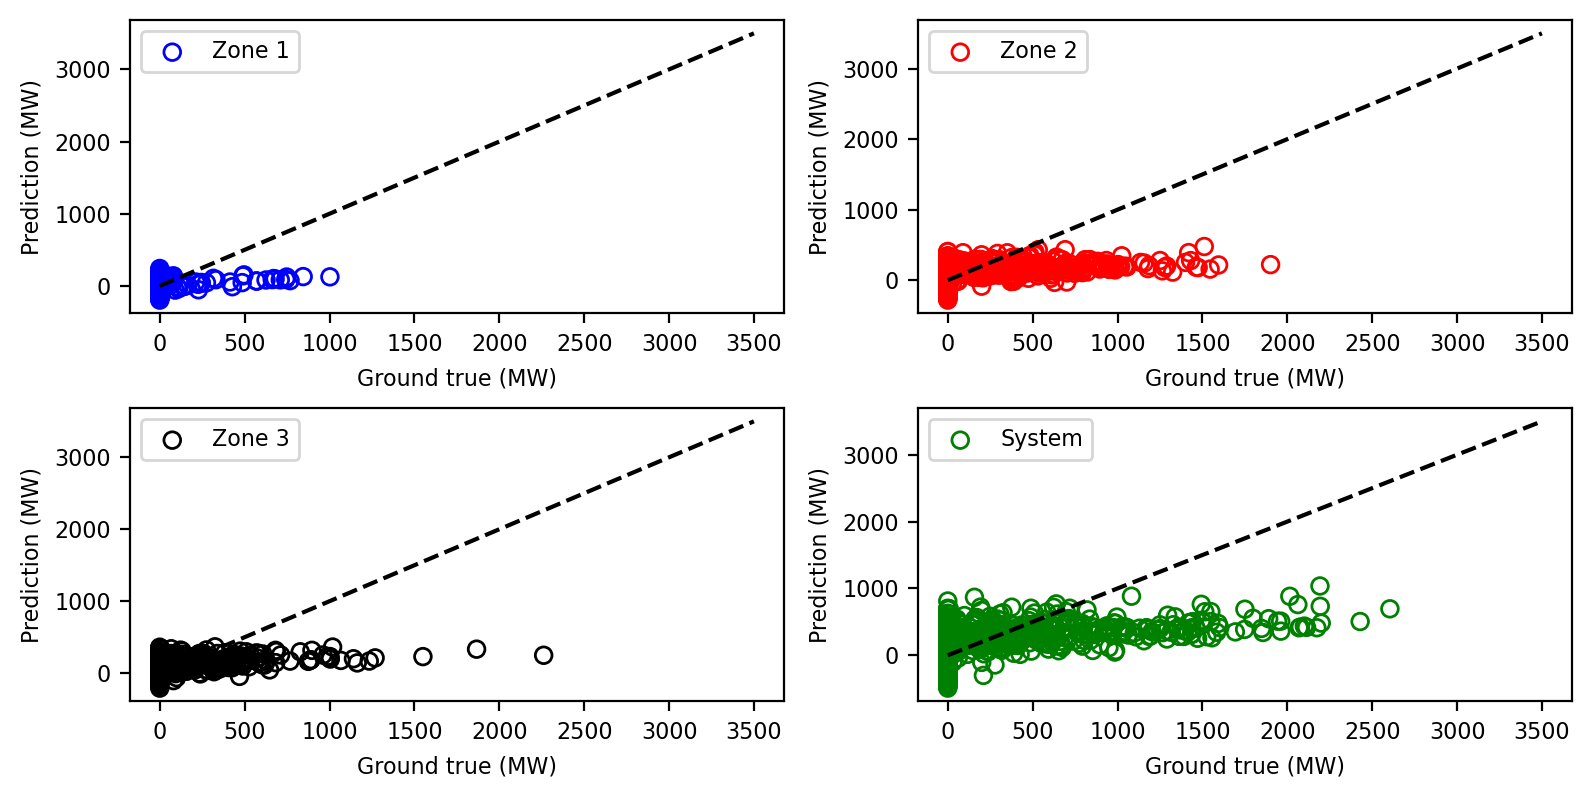

In [14]:
x = np.linspace(0, 3500, 100)
y = x

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(221)
ax1.plot(x, y, color='black', linestyle='dashed')
ax1.scatter(shedding_true[:, 0], shedding_pred[:, 0], marker='o', facecolors='none', edgecolors='blue', label='Zone 1')
ax1.set_xlabel('Ground true (MW)')
ax1.set_ylabel('Prediction (MW)')
ax1.legend()

ax2 = fig.add_subplot(222)
ax2.plot(x, y, color='black', linestyle='dashed')
ax2.scatter(shedding_true[:, 1], shedding_pred[:, 1], marker='o', facecolors='none', edgecolors='red', label='Zone 2')
ax2.set_xlabel('Ground true (MW)')
ax2.set_ylabel('Prediction (MW)')
ax2.legend()

ax3 = fig.add_subplot(223)
ax3.plot(x, y, color='black', linestyle='dashed')
ax3.scatter(shedding_true[:, 2], shedding_pred[:, 2], marker='o', facecolors='none', edgecolors='black', label='Zone 3')
ax3.set_xlabel('Ground true (MW)')
ax3.set_ylabel('Prediction (MW)')
ax3.legend()

ax4 = fig.add_subplot(224)
ax4.plot(x, y, color='black', linestyle='dashed')
ax4.scatter(shedding_true[:, 3], shedding_pred[:, 3], marker='o', facecolors='none', edgecolors='green', label='System')
ax4.set_xlabel('Ground true (MW)')
ax4.set_ylabel('Prediction (MW)')
ax4.legend()

plt.tight_layout()
plt.show()
plt.close('all')

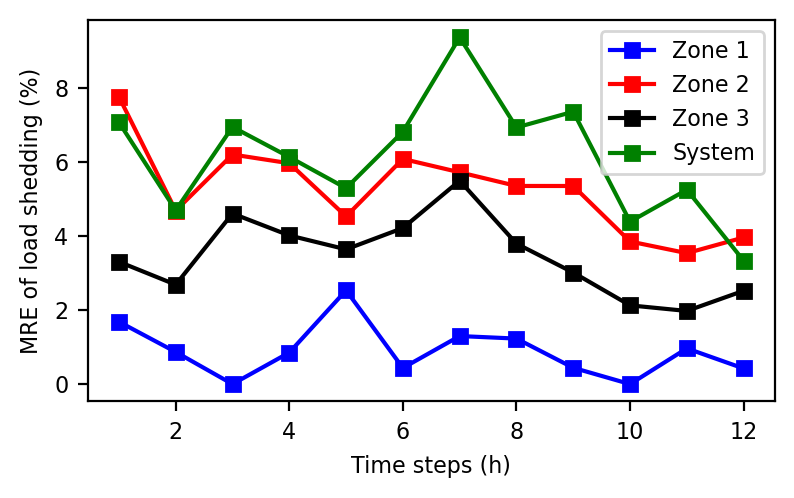

In [15]:
x = np.arange(1, 13)

fig = plt.figure(figsize=(4, 2.5))
ax = fig.add_subplot(111)
ax.plot(x, shedding_mre[0], color='blue', marker='s', markersize=5, label='Zone 1')
ax.plot(x, shedding_mre[1], color='red', marker='s', markersize=5, label='Zone 2')
ax.plot(x, shedding_mre[2], color='black', marker='s', markersize=5, label='Zone 3')
ax.plot(x, shedding_mre[3], color='green', marker='s', markersize=5, label='System')
ax.set_xlabel('Time steps (h)')
# ax.set_ylim((0, 40))
ax.set_ylabel('MRE of load shedding (%)')
ax.legend()

plt.tight_layout()
plt.show()
plt.close('all')

##### Save PF prediction

In [16]:
# Read PTDF matrix
file_path = f'../../data/IEEE_Case118/PTDF/PTDF_matrix.csv'
PTDF = pd.read_csv(file_path, header=None, index_col=None).to_numpy()

# Read wind input
# wind = np.zeros((num_data, num_buses, nt))
wind = np.zeros((num_data, num_buses, nt))
for i, loader in enumerate(test_loader):
    temp = loader.x.detach().numpy()[wind_bidx, -2*nt:-nt]
    wind[i, wind_bidx] = temp.copy()

for i in range(num_data):
    # Read PG true
    file_path = f'./model_evaluation/ANN/PG_true/true_{i+1}.csv'
    PG_true = pd.read_csv(file_path, index_col=None, header=None).to_numpy()
    # Read DL true
    file_path = f'./model_evaluation/ANN/DL_true/true_{i+1}.csv'
    DL_true = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    # DL_true = np.zeros((num_buses, nt))
    # DL_true[load_bidx] = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    PB_true = wind[i] + PG_true - DL_true
    PF_true = np.round(PTDF@PB_true, 2)
    file_path = f'model_evaluation/ANN/PF_true/true_{i+1}.csv'
    pd.DataFrame(PF_true).to_csv(file_path, columns=None, index=None, header=None)

    # Read PG prediction
    file_path = f'./model_evaluation/ANN/PG_pred/pred_{i+1}.csv'
    PG_pred = pd.read_csv(file_path, index_col=None, header=None).to_numpy()
    # Read DL prediction
    file_path = f'./model_evaluation/ANN/DL_pred/pred_{i+1}.csv'
    DL_pred = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    # DL_pred = np.zeros((num_buses, nt))
    # DL_pred[load_bidx] = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    PB_pred = wind[i] + PG_pred - DL_pred
    PF_pred = np.round(PTDF@PB_pred, 2)
    file_path = f'model_evaluation/ANN/PF_pred/pred_{i+1}.csv'
    pd.DataFrame(PF_pred).to_csv(file_path, columns=None, index=None, header=None)

## SAGE

#### MRE of PG

In [10]:
# Overall number of PG
num_data = 200

# Record relative error
rela_err = np.zeros((num_data, thermal_bidx.sum(), nt))

for i in range(num_data):
    # Read PG true
    file_path = f'./model_evaluation/SAGE/PG_true/true_{i+1}.csv'
    PG_true = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    PG_true = PG_true[thermal_bidx]
    PG_true = np.round(PG_true, 2)

    # Read PG prediction
    file_path = f'./model_evaluation/SAGE/PG_pred/pred_{i+1}.csv'
    PG_pred = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    PG_pred = PG_pred[thermal_bidx]
    PG_pred = np.round(PG_pred, 2)

    # Calculate relative error
    indices = np.where(PG_true!=0) 
    rela_err[i][indices] = np.abs((PG_true[indices] - PG_pred[indices]) / PG_true[indices]) * 100

    indices = np.where((PG_true == 0) & (PG_pred == 0))
    rela_err[i][indices] = 0.

    indices = np.where((PG_true == 0) & (PG_pred != 0))
    rela_err[i][indices] = np.NaN

# Don't count the case where the relative error is inf
mre = np.nanmean(rela_err, axis=0)

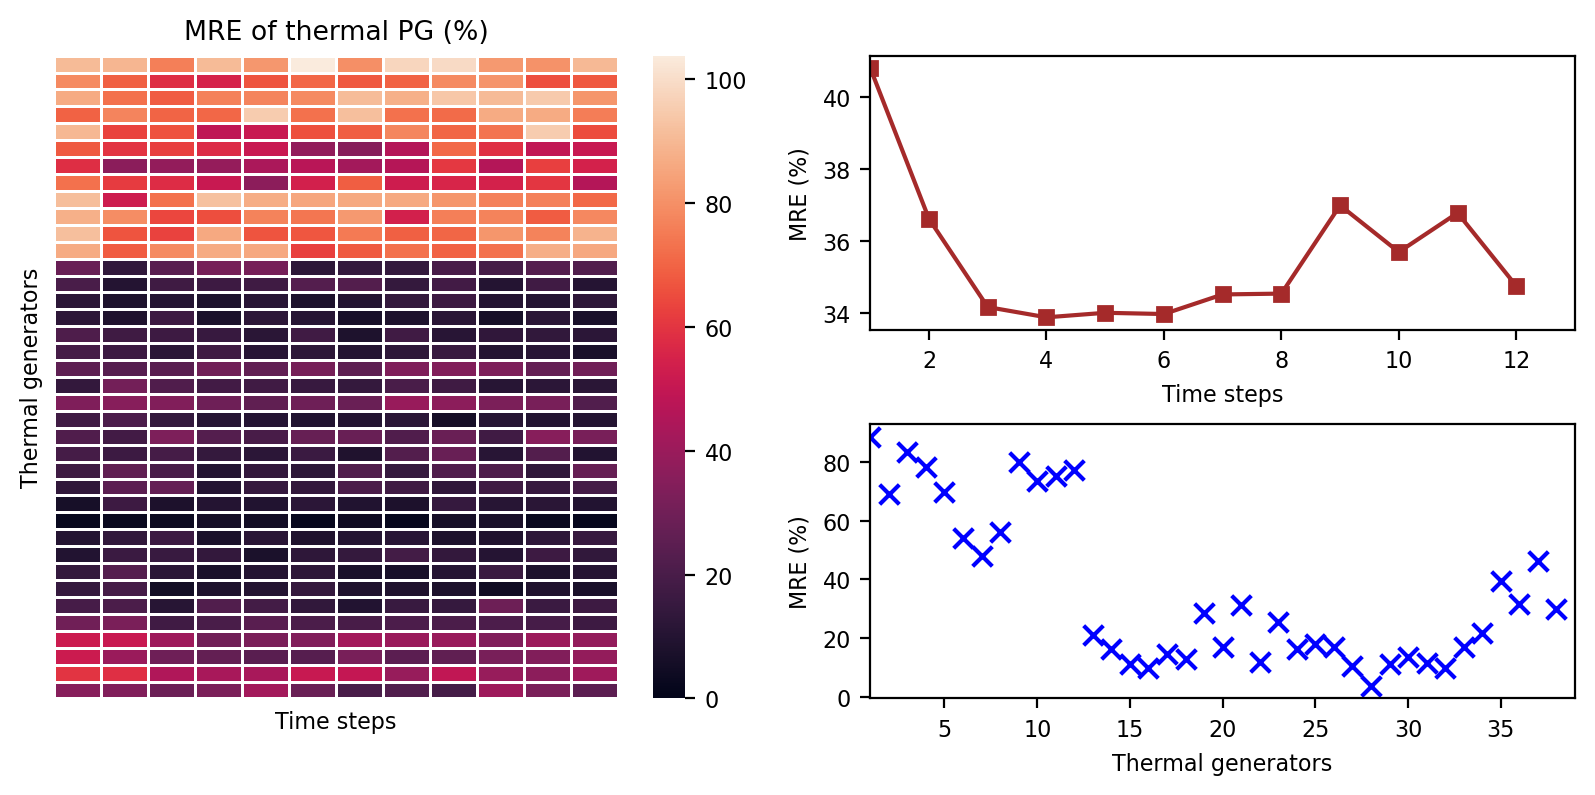

In [11]:
# Plot mean relative error
fig = plt.figure(figsize=(8, 4))
gs = GridSpec(2, 2)

ax = plt.subplot(gs[:, 0])
sns.heatmap(mre, 
            ax=ax,
            vmin=0,
            # vmax=100,
            xticklabels=[],
            yticklabels=[],
            linewidth=0.5)
ax.set_title('MRE of thermal PG (%)')
ax.set_xlabel('Time steps')
ax.set_ylabel('Thermal generators')

x = np.arange(1, 13)
mre_avg = mre.mean(axis=0)
ax = plt.subplot(gs[0, 1])
ax.plot(x, mre_avg, marker='s', color='brown', markersize=5)
ax.set_xlim((1, 13))
# ax.set_ylim((0, 10))
ax.set_xlabel('Time steps')
ax.set_ylabel('MRE (%)')

x = np.arange(1, 39)
mre_avg = mre.mean(axis=1)
ax = plt.subplot(gs[1, 1])
ax.scatter(x, mre_avg, marker='x', color='blue', s=50)
ax.set_xlim((1, 39))
ax.set_xlabel('Thermal generators')
ax.set_ylabel('MRE (%)')

plt.tight_layout()
plt.show()
plt.close('all')

##### MRE of aggregated PG

In [12]:
# Buses in each zone
file_path = '../../data/IEEE_Case118/zones/zone1_bus.csv'
zone1_buses = pd.read_csv(file_path, header=None, index_col=None).to_numpy()

file_path = '../../data/IEEE_Case118/zones/zone2_bus.csv'
zone2_buses = pd.read_csv(file_path, header=None, index_col=None).to_numpy()

file_path = '../../data/IEEE_Case118/zones/zone3_bus.csv'
zone3_buses = pd.read_csv(file_path, header=None, index_col=None).to_numpy()

# Thermal bidx in each zone
thermal_bidx_zone1 = np.isin(thermal_buses, zone1_buses).flatten()
thermal_bidx_zone2 = np.isin(thermal_buses, zone2_buses).flatten()
thermal_bidx_zone3 = np.isin(thermal_buses, zone3_buses).flatten()

In [13]:
# Number of zones
num_zones = 3

# PG sum
PG_sum_true = np.zeros((num_data, num_zones+1, nt))
PG_sum_pred = np.zeros((num_data, num_zones+1, nt))

for i in range(num_data):
    # Read PG true
    file_path = f'./model_evaluation/SAGE/PG_true/true_{i+1}.csv'
    PG_true = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    PG_true = PG_true[thermal_bidx, :nt]
    PG_true = np.round(PG_true, 2)
    temp0 = PG_true[thermal_bidx_zone1].sum(axis=0)
    temp1 = PG_true[thermal_bidx_zone2].sum(axis=0)
    temp2 = PG_true[thermal_bidx_zone3].sum(axis=0)
    temp3 = PG_true.sum(axis=0)
    PG_sum_true[i, 0] = temp0.copy()
    PG_sum_true[i, 1] = temp1.copy()
    PG_sum_true[i, 2] = temp2.copy()
    PG_sum_true[i, 3] = temp3.copy()

    # Read PG prediction
    file_path = f'./model_evaluation/SAGE/PG_pred/pred_{i+1}.csv'
    PG_pred = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    PG_pred = PG_pred[thermal_bidx]
    PG_pred = np.round(PG_pred, 2)
    temp0 = PG_pred[thermal_bidx_zone1].sum(axis=0)
    temp1 = PG_pred[thermal_bidx_zone2].sum(axis=0)
    temp2 = PG_pred[thermal_bidx_zone3].sum(axis=0)
    temp3 = PG_pred.sum(axis=0)
    PG_sum_pred[i, 0] = temp0.copy()
    PG_sum_pred[i, 1] = temp1.copy()
    PG_sum_pred[i, 2] = temp2.copy()
    PG_sum_pred[i, 3] = temp3.copy()

# Calculate relative error
rela_err = np.abs((PG_sum_true - PG_sum_pred) / PG_sum_true) * 100

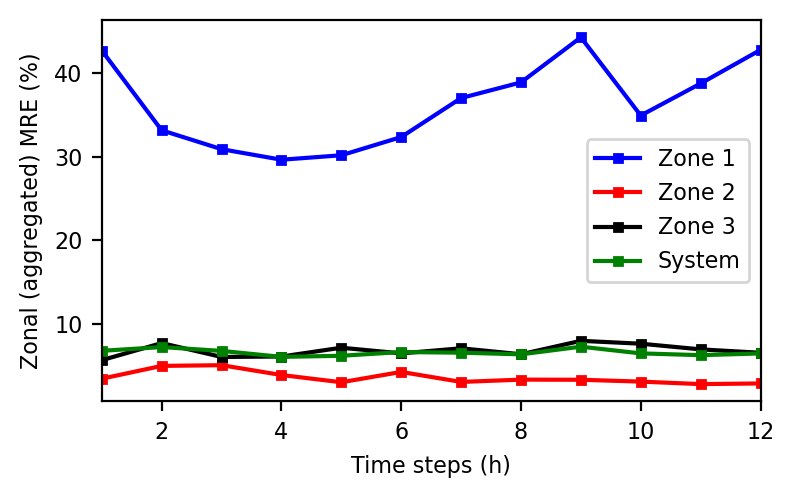

In [14]:
# Plot mean zonal aggregated PG relative error
fig = plt.figure(figsize=(4, 2.5))
ax = fig.add_subplot(1, 1, 1)
# Zone 1 aggregated PG
ax.plot(np.arange(12)+1, rela_err.mean(axis=0)[0], color='blue', marker='s', markersize=3, label='Zone 1')
# Zone 1 aggregated PG
ax.plot(np.arange(12)+1, rela_err.mean(axis=0)[1], color='red', marker='s', markersize=3, label='Zone 2')
# Zone 1 aggregated PG
ax.plot(np.arange(12)+1, rela_err.mean(axis=0)[2], color='black', marker='s', markersize=3, label='Zone 3')
# System aggregated PG
ax.plot(np.arange(12)+1, rela_err.mean(axis=0)[3], color='green', marker='s', markersize=3, label='System')

ax.set_xlim((1, 12))
# ax.set_ylim((0, 6))
ax.set_xlabel('Time steps (h)')
ax.set_ylabel('Zonal (aggregated) MRE (%)')
ax.legend()

plt.tight_layout()
plt.show()
plt.close('all')

##### MRE of DL

In [15]:
# Overall number of DL
num_data = 200

# Record relative error
rela_err = np.zeros((num_data, load_bidx.sum(), nt))

for i in range(num_data):
    # Read DL true
    file_path = f'./model_evaluation/SAGE/DL_true/true_{i+1}.csv'
    DL_true = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    DL_true = DL_true[load_bidx]
    DL_true = np.round(DL_true, 2)

    # Read DL prediction
    file_path = f'./model_evaluation/SAGE/DL_pred/pred_{i+1}.csv'
    DL_pred = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    DL_pred = DL_pred[load_bidx]
    DL_pred = np.round(DL_pred, 2)
    
    # Calculate relative error
    indices = np.where(DL_true!=0) 
    rela_err[i][indices] = np.abs((DL_true[indices] - DL_pred[indices]) / DL_true[indices]) * 100

    indices = np.where((DL_true == 0) & (DL_pred == 0))
    rela_err[i][indices] = 0.

    indices = np.where((DL_true == 0) & (DL_pred != 0))
    rela_err[i][indices] = np.NaN

# Don't count the case where the relative error is inf
mre = np.nanmean(rela_err, axis=0)

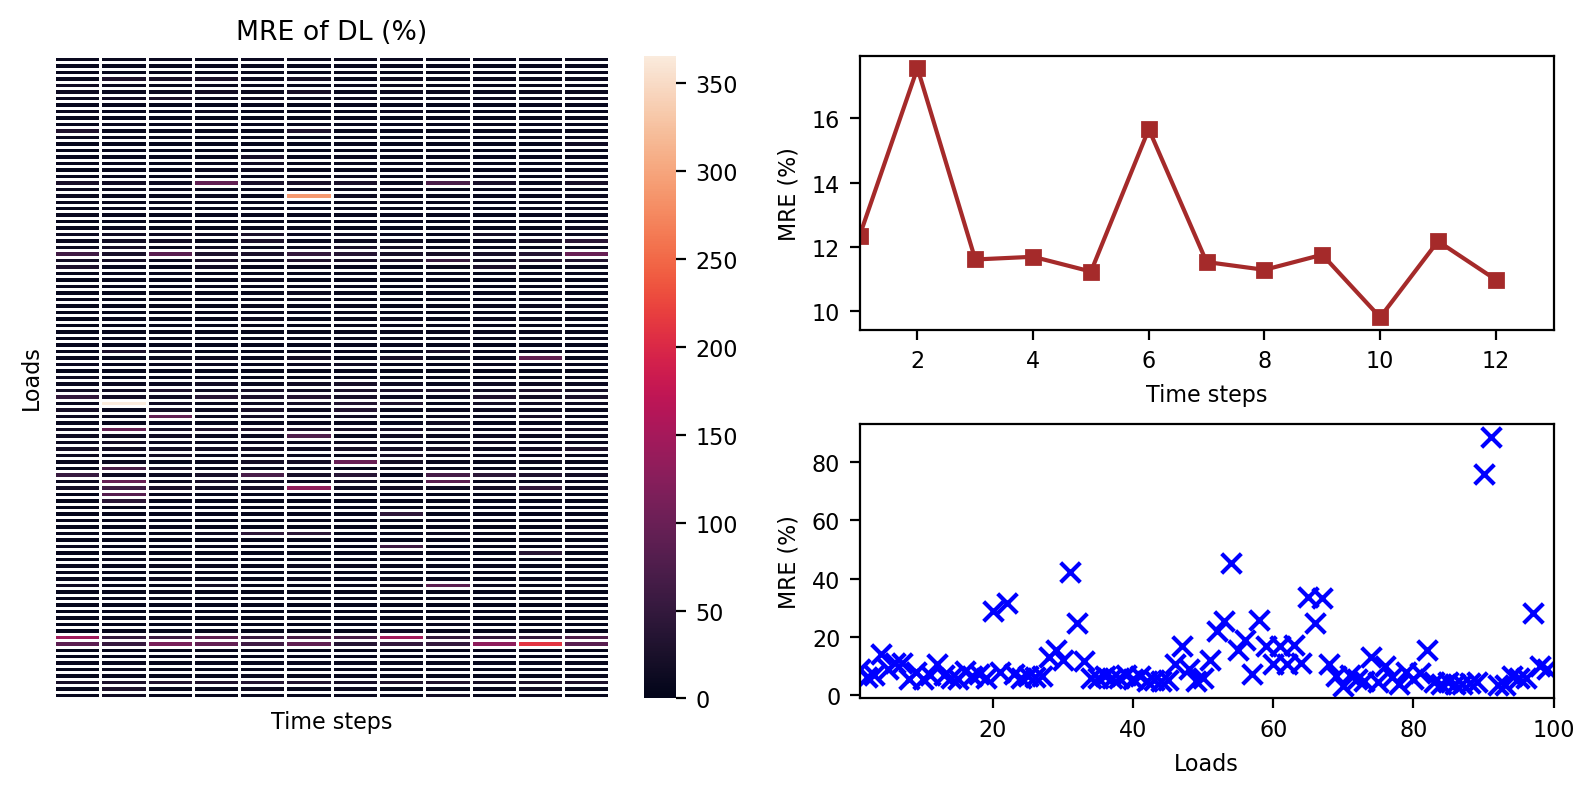

In [16]:
# Plot mean relative error
fig = plt.figure(figsize=(8, 4))
gs = GridSpec(2, 2)

ax = plt.subplot(gs[:, 0])
sns.heatmap(mre, 
            ax=ax,
            vmin=0,
            xticklabels=[],
            yticklabels=[],
            linewidth=0.5)
ax.set_title('MRE of DL (%)')
ax.set_xlabel('Time steps')
ax.set_ylabel('Loads')

x = np.arange(1, 13)
mre_avg = mre.mean(axis=0)
ax = plt.subplot(gs[0, 1])
ax.plot(x, mre_avg, marker='s', color='brown', markersize=5)
ax.set_xlim((1, 13))
ax.set_xlabel('Time steps')
ax.set_ylabel('MRE (%)')

x = np.arange(1, load_bidx.sum()+1)
mre_avg = mre.mean(axis=1)
ax = plt.subplot(gs[1, 1])
ax.scatter(x, mre_avg, marker='x', color='blue', s=50)
ax.set_xlim((1, load_bidx.sum()+1))
ax.set_xlabel('Loads')
ax.set_ylabel('MRE (%)')

plt.tight_layout()
plt.show()
plt.close('all')

#### Load shedding

In [17]:
# Root
root = '../../train_val_test_dataset/IEEE_Case118/DL-SAGE'

# Load all data with empty input
dataset = MyDataset(root=root, data_list=[])

# Get train dataset
test_size = 200

test_dataset = dataset[-test_size:]

# Create train loader
############ Shuffle cannot be true for testing data ##############
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [18]:
# Load bidx in each zone
load_bidx_zone1 = np.isin(load_buses, zone1_buses).flatten()
load_bidx_zone2 = np.isin(load_buses, zone2_buses).flatten()
load_bidx_zone3 = np.isin(load_buses, zone3_buses).flatten()

In [19]:
# Get load inputs
load_input = np.zeros((num_data, num_zones+1, nt))

for i, loader in enumerate(test_loader):
    # Get load input of individual graph
    temp = loader.x.detach().numpy()[load_bidx, -nt:]
    load_input[i, 0] = temp[load_bidx_zone1].sum(axis=0)
    load_input[i, 1] = temp[load_bidx_zone2].sum(axis=0)
    load_input[i, 2] = temp[load_bidx_zone3].sum(axis=0)
    load_input[i, 3] = temp.sum(axis=0)

# Read DL ground truth and prediction
DL_true= np.zeros((num_data, num_zones+1, nt))
DL_pred = np.zeros((num_data, num_zones+1, nt))
for i in range(num_data):
    file_path = f'model_evaluation/SAGE/DL_true/true_{i+1}.csv'
    temp = pd.read_csv(file_path, header=None, index_col=None).to_numpy()[load_bidx]
    # temp = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    DL_true[i, 0] = temp[load_bidx_zone1].sum(axis=0)
    DL_true[i, 1] = temp[load_bidx_zone2].sum(axis=0)
    DL_true[i, 2] = temp[load_bidx_zone3].sum(axis=0)
    DL_true[i, 3] = temp.sum(axis=0)

    file_path = f'model_evaluation/SAGE/DL_pred/pred_{i+1}.csv'
    temp = pd.read_csv(file_path, header=None, index_col=None).to_numpy()[load_bidx]
    # temp = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    DL_pred[i, 0] = temp[load_bidx_zone1].sum(axis=0)
    DL_pred[i, 1] = temp[load_bidx_zone2].sum(axis=0)
    DL_pred[i, 2] = temp[load_bidx_zone3].sum(axis=0)
    DL_pred[i, 3] = temp.sum(axis=0)

In [20]:
# Calculate shedding
shedding_true = load_input - DL_true
shedding_pred = load_input - DL_pred

shedding_rela_err = np.zeros(shedding_true.shape)

# Set relative error = NaN for zero ground truth
indices = np.where(np.abs(shedding_true) <= 0)
shedding_rela_err[indices] = np.NaN

# Calculate relative error for nonzero ground truth
indices = np.where(np.abs(shedding_true) > 200)
shedding_rela_err[indices] = np.abs((shedding_true[indices] - shedding_pred[indices]) / shedding_true[indices]) * 100

# Calculate MRE of load shedding
shedding_mre = np.nanmean(shedding_rela_err, axis=0)

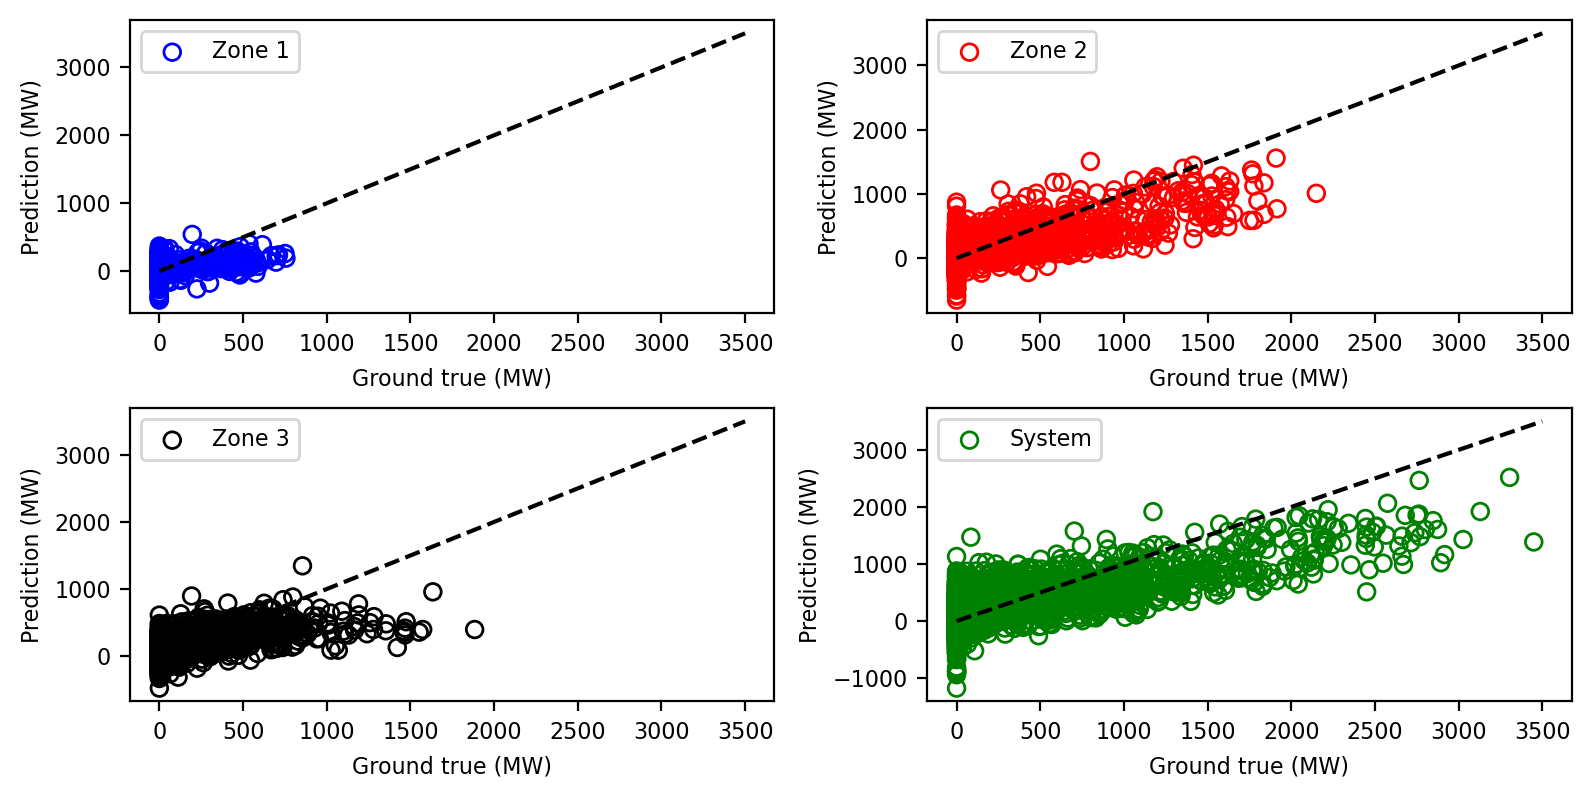

In [21]:
x = np.linspace(0, 3500, 100)
y = x

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(221)
ax1.plot(x, y, color='black', linestyle='dashed')
ax1.scatter(shedding_true[:, 0], shedding_pred[:, 0], marker='o', facecolors='none', edgecolors='blue', label='Zone 1')
ax1.set_xlabel('Ground true (MW)')
ax1.set_ylabel('Prediction (MW)')
ax1.legend()

ax2 = fig.add_subplot(222)
ax2.plot(x, y, color='black', linestyle='dashed')
ax2.scatter(shedding_true[:, 1], shedding_pred[:, 1], marker='o', facecolors='none', edgecolors='red', label='Zone 2')
ax2.set_xlabel('Ground true (MW)')
ax2.set_ylabel('Prediction (MW)')
ax2.legend()

ax3 = fig.add_subplot(223)
ax3.plot(x, y, color='black', linestyle='dashed')
ax3.scatter(shedding_true[:, 2], shedding_pred[:, 2], marker='o', facecolors='none', edgecolors='black', label='Zone 3')
ax3.set_xlabel('Ground true (MW)')
ax3.set_ylabel('Prediction (MW)')
ax3.legend()

ax4 = fig.add_subplot(224)
ax4.plot(x, y, color='black', linestyle='dashed')
ax4.scatter(shedding_true[:, 3], shedding_pred[:, 3], marker='o', facecolors='none', edgecolors='green', label='System')
ax4.set_xlabel('Ground true (MW)')
ax4.set_ylabel('Prediction (MW)')
ax4.legend()

plt.tight_layout()
plt.show()
plt.close('all')

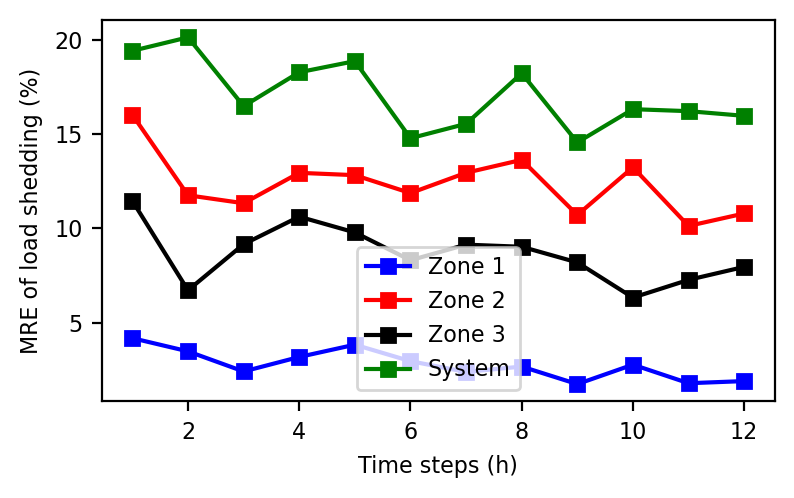

In [22]:
x = np.arange(1, 13)

fig = plt.figure(figsize=(4, 2.5))
ax = fig.add_subplot(111)
ax.plot(x, shedding_mre[0], color='blue', marker='s', markersize=5, label='Zone 1')
ax.plot(x, shedding_mre[1], color='red', marker='s', markersize=5, label='Zone 2')
ax.plot(x, shedding_mre[2], color='black', marker='s', markersize=5, label='Zone 3')
ax.plot(x, shedding_mre[3], color='green', marker='s', markersize=5, label='System')
ax.set_xlabel('Time steps (h)')
# ax.set_ylim((0, 40))
ax.set_ylabel('MRE of load shedding (%)')
ax.legend()

plt.tight_layout()
plt.show()
plt.close('all')

##### Save PF prediction

In [23]:
# Read PTDF matrix
file_path = f'../../data/IEEE_Case118/PTDF/PTDF_matrix.csv'
PTDF = pd.read_csv(file_path, header=None, index_col=None).to_numpy()

# Read wind input
# wind = np.zeros((num_data, num_buses, nt))
wind = np.zeros((num_data, num_buses, nt))
for i, loader in enumerate(test_loader):
    temp = loader.x.detach().numpy()[wind_bidx, -2*nt:-nt]
    wind[i, wind_bidx] = temp.copy()

for i in range(num_data):
    # Read PG true
    file_path = f'./model_evaluation/SAGE/PG_true/true_{i+1}.csv'
    PG_true = pd.read_csv(file_path, index_col=None, header=None).to_numpy()
    # Read DL true
    file_path = f'./model_evaluation/SAGE/DL_true/true_{i+1}.csv'
    DL_true = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    # DL_true = np.zeros((num_buses, nt))
    # DL_true[load_bidx] = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    PB_true = wind[i] + PG_true - DL_true
    PF_true = np.round(PTDF@PB_true, 2)
    file_path = f'model_evaluation/SAGE/PF_true/true_{i+1}.csv'
    pd.DataFrame(PF_true).to_csv(file_path, columns=None, index=None, header=None)

    # Read PG prediction
    file_path = f'./model_evaluation/SAGE/PG_pred/pred_{i+1}.csv'
    PG_pred = pd.read_csv(file_path, index_col=None, header=None).to_numpy()
    # Read DL prediction
    file_path = f'./model_evaluation/SAGE/DL_pred/pred_{i+1}.csv'
    DL_pred = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    # DL_pred = np.zeros((num_buses, nt))
    # DL_pred[load_bidx] = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    PB_pred = wind[i] + PG_pred - DL_pred
    PF_pred = np.round(PTDF@PB_pred, 2)
    file_path = f'model_evaluation/SAGE/PF_pred/pred_{i+1}.csv'
    pd.DataFrame(PF_pred).to_csv(file_path, columns=None, index=None, header=None)

## GCN

#### MRE of PG

In [31]:
# Overall number of PG
num_data = 200

# Record relative error
rela_err = np.zeros((num_data, thermal_bidx.sum(), nt))

for i in range(num_data):
    # Read PG true
    file_path = f'./model_evaluation/GCN/PG_true/true_{i+1}.csv'
    PG_true = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    PG_true = PG_true[thermal_bidx]
    PG_true = np.round(PG_true, 2)

    # Read PG prediction
    file_path = f'./model_evaluation/GCN/PG_pred/pred_{i+1}.csv'
    PG_pred = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    PG_pred = PG_pred[thermal_bidx]
    PG_pred = np.round(PG_pred, 2)

    # Calculate relative error
    indices = np.where(PG_true!=0) 
    rela_err[i][indices] = np.abs((PG_true[indices] - PG_pred[indices]) / PG_true[indices]) * 100

    indices = np.where((PG_true == 0) & (PG_pred == 0))
    rela_err[i][indices] = 0.

    indices = np.where((PG_true == 0) & (PG_pred != 0))
    rela_err[i][indices] = np.NaN

# Don't count the case where the relative error is inf
mre = np.nanmean(rela_err, axis=0)

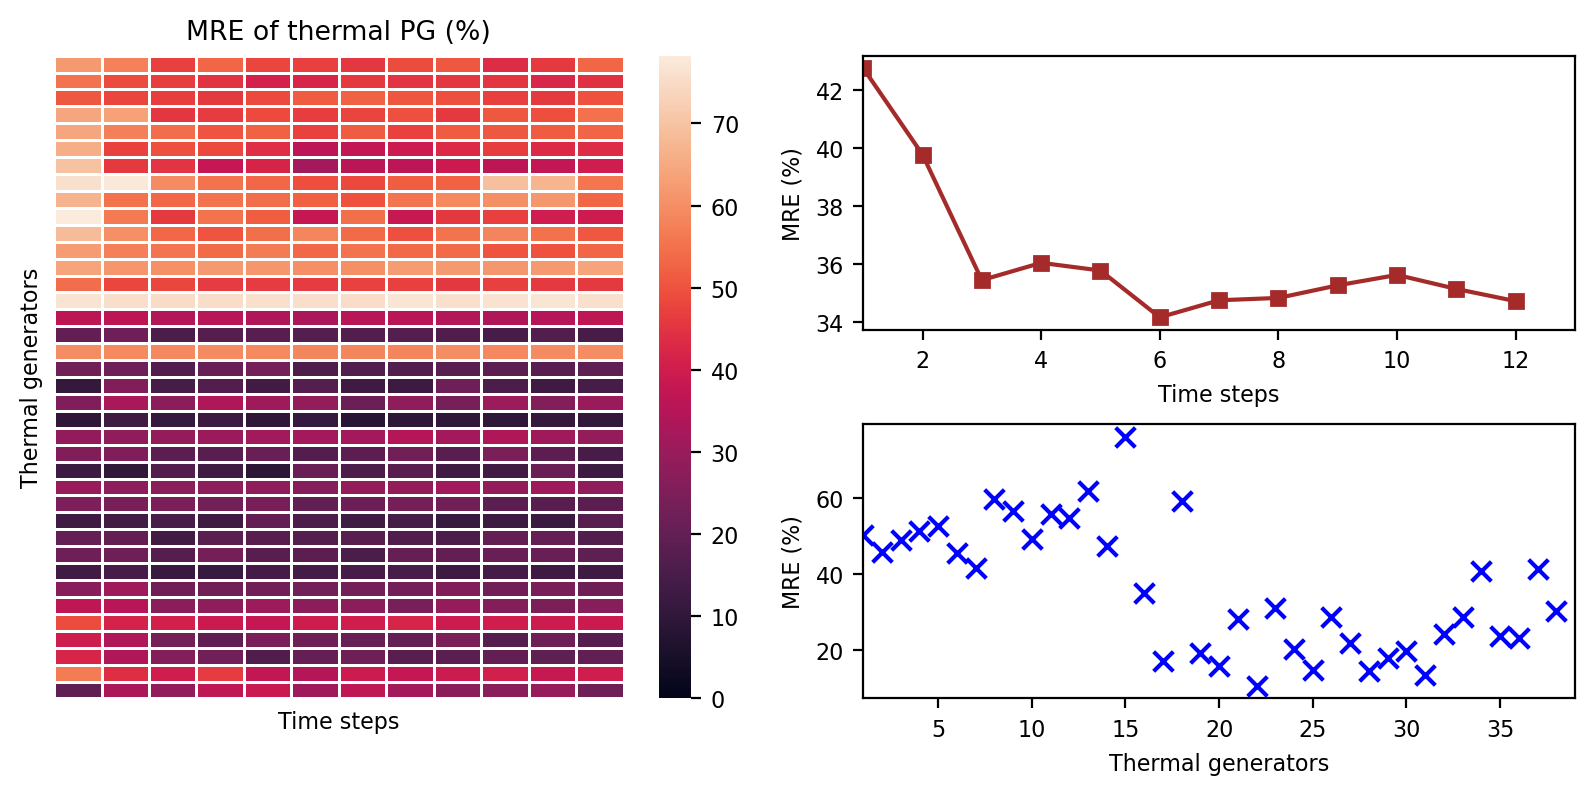

In [32]:
# Plot mean relative error
fig = plt.figure(figsize=(8, 4))
gs = GridSpec(2, 2)

ax = plt.subplot(gs[:, 0])
sns.heatmap(mre, 
            ax=ax,
            vmin=0,
            # vmax=100,
            xticklabels=[],
            yticklabels=[],
            linewidth=0.5)
ax.set_title('MRE of thermal PG (%)')
ax.set_xlabel('Time steps')
ax.set_ylabel('Thermal generators')

x = np.arange(1, 13)
mre_avg = mre.mean(axis=0)
ax = plt.subplot(gs[0, 1])
ax.plot(x, mre_avg, marker='s', color='brown', markersize=5)
ax.set_xlim((1, 13))
# ax.set_ylim((0, 10))
ax.set_xlabel('Time steps')
ax.set_ylabel('MRE (%)')

x = np.arange(1, 39)
mre_avg = mre.mean(axis=1)
ax = plt.subplot(gs[1, 1])
ax.scatter(x, mre_avg, marker='x', color='blue', s=50)
ax.set_xlim((1, 39))
ax.set_xlabel('Thermal generators')
ax.set_ylabel('MRE (%)')

plt.tight_layout()
plt.show()
plt.close('all')

##### MRE of aggregated PG

In [33]:
# Buses in each zone
file_path = '../../data/IEEE_Case118/zones/zone1_bus.csv'
zone1_buses = pd.read_csv(file_path, header=None, index_col=None).to_numpy()

file_path = '../../data/IEEE_Case118/zones/zone2_bus.csv'
zone2_buses = pd.read_csv(file_path, header=None, index_col=None).to_numpy()

file_path = '../../data/IEEE_Case118/zones/zone3_bus.csv'
zone3_buses = pd.read_csv(file_path, header=None, index_col=None).to_numpy()

# Thermal bidx in each zone
thermal_bidx_zone1 = np.isin(thermal_buses, zone1_buses).flatten()
thermal_bidx_zone2 = np.isin(thermal_buses, zone2_buses).flatten()
thermal_bidx_zone3 = np.isin(thermal_buses, zone3_buses).flatten()

In [34]:
# Number of zones
num_zones = 3

# PG sum
PG_sum_true = np.zeros((num_data, num_zones+1, nt))
PG_sum_pred = np.zeros((num_data, num_zones+1, nt))

for i in range(num_data):
    # Read PG true
    file_path = f'./model_evaluation/GCN/PG_true/true_{i+1}.csv'
    PG_true = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    PG_true = PG_true[thermal_bidx, :nt]
    PG_true = np.round(PG_true, 2)
    temp0 = PG_true[thermal_bidx_zone1].sum(axis=0)
    temp1 = PG_true[thermal_bidx_zone2].sum(axis=0)
    temp2 = PG_true[thermal_bidx_zone3].sum(axis=0)
    temp3 = PG_true.sum(axis=0)
    PG_sum_true[i, 0] = temp0.copy()
    PG_sum_true[i, 1] = temp1.copy()
    PG_sum_true[i, 2] = temp2.copy()
    PG_sum_true[i, 3] = temp3.copy()

    # Read PG prediction
    file_path = f'./model_evaluation/GCN/PG_pred/pred_{i+1}.csv'
    PG_pred = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    PG_pred = PG_pred[thermal_bidx]
    PG_pred = np.round(PG_pred, 2)
    temp0 = PG_pred[thermal_bidx_zone1].sum(axis=0)
    temp1 = PG_pred[thermal_bidx_zone2].sum(axis=0)
    temp2 = PG_pred[thermal_bidx_zone3].sum(axis=0)
    temp3 = PG_pred.sum(axis=0)
    PG_sum_pred[i, 0] = temp0.copy()
    PG_sum_pred[i, 1] = temp1.copy()
    PG_sum_pred[i, 2] = temp2.copy()
    PG_sum_pred[i, 3] = temp3.copy()

# Calculate relative error
rela_err = np.abs((PG_sum_true - PG_sum_pred) / PG_sum_true) * 100

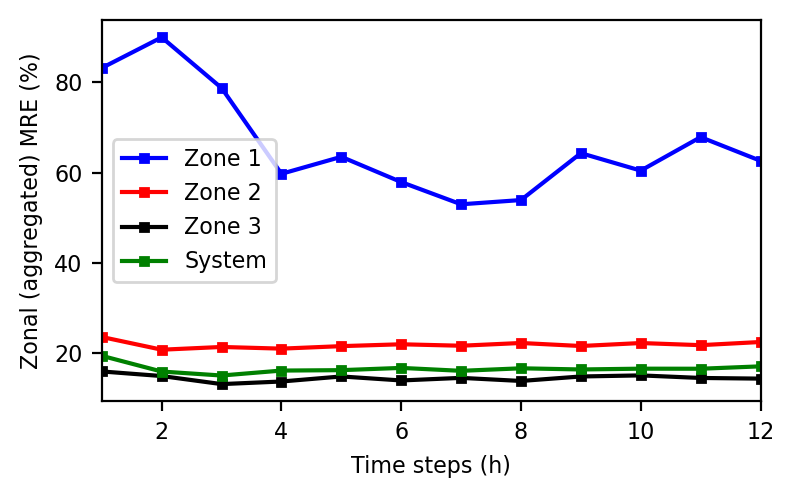

In [35]:
# Plot mean zonal aggregated PG relative error
fig = plt.figure(figsize=(4, 2.5))
ax = fig.add_subplot(1, 1, 1)
# Zone 1 aggregated PG
ax.plot(np.arange(12)+1, rela_err.mean(axis=0)[0], color='blue', marker='s', markersize=3, label='Zone 1')
# Zone 1 aggregated PG
ax.plot(np.arange(12)+1, rela_err.mean(axis=0)[1], color='red', marker='s', markersize=3, label='Zone 2')
# Zone 1 aggregated PG
ax.plot(np.arange(12)+1, rela_err.mean(axis=0)[2], color='black', marker='s', markersize=3, label='Zone 3')
# System aggregated PG
ax.plot(np.arange(12)+1, rela_err.mean(axis=0)[3], color='green', marker='s', markersize=3, label='System')

ax.set_xlim((1, 12))
# ax.set_ylim((0, 6))
ax.set_xlabel('Time steps (h)')
ax.set_ylabel('Zonal (aggregated) MRE (%)')
ax.legend()

plt.tight_layout()
plt.show()
plt.close('all')

##### MRE of DL

In [36]:
# Overall number of DL
num_data = 200

# Record relative error
rela_err = np.zeros((num_data, load_bidx.sum(), nt))

for i in range(num_data):
    # Read DL true
    file_path = f'./model_evaluation/GCN/DL_true/true_{i+1}.csv'
    DL_true = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    DL_true = DL_true[load_bidx]
    DL_true = np.round(DL_true, 2)

    # Read DL prediction
    file_path = f'./model_evaluation/GCN/DL_pred/pred_{i+1}.csv'
    DL_pred = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    DL_pred = DL_pred[load_bidx]
    DL_pred = np.round(DL_pred, 2)
    
    # Calculate relative error
    indices = np.where(DL_true!=0) 
    rela_err[i][indices] = np.abs((DL_true[indices] - DL_pred[indices]) / DL_true[indices]) * 100

    indices = np.where((DL_true == 0) & (DL_pred == 0))
    rela_err[i][indices] = 0.

    indices = np.where((DL_true == 0) & (DL_pred != 0))
    rela_err[i][indices] = np.NaN

# Don't count the case where the relative error is inf
mre = np.nanmean(rela_err, axis=0)

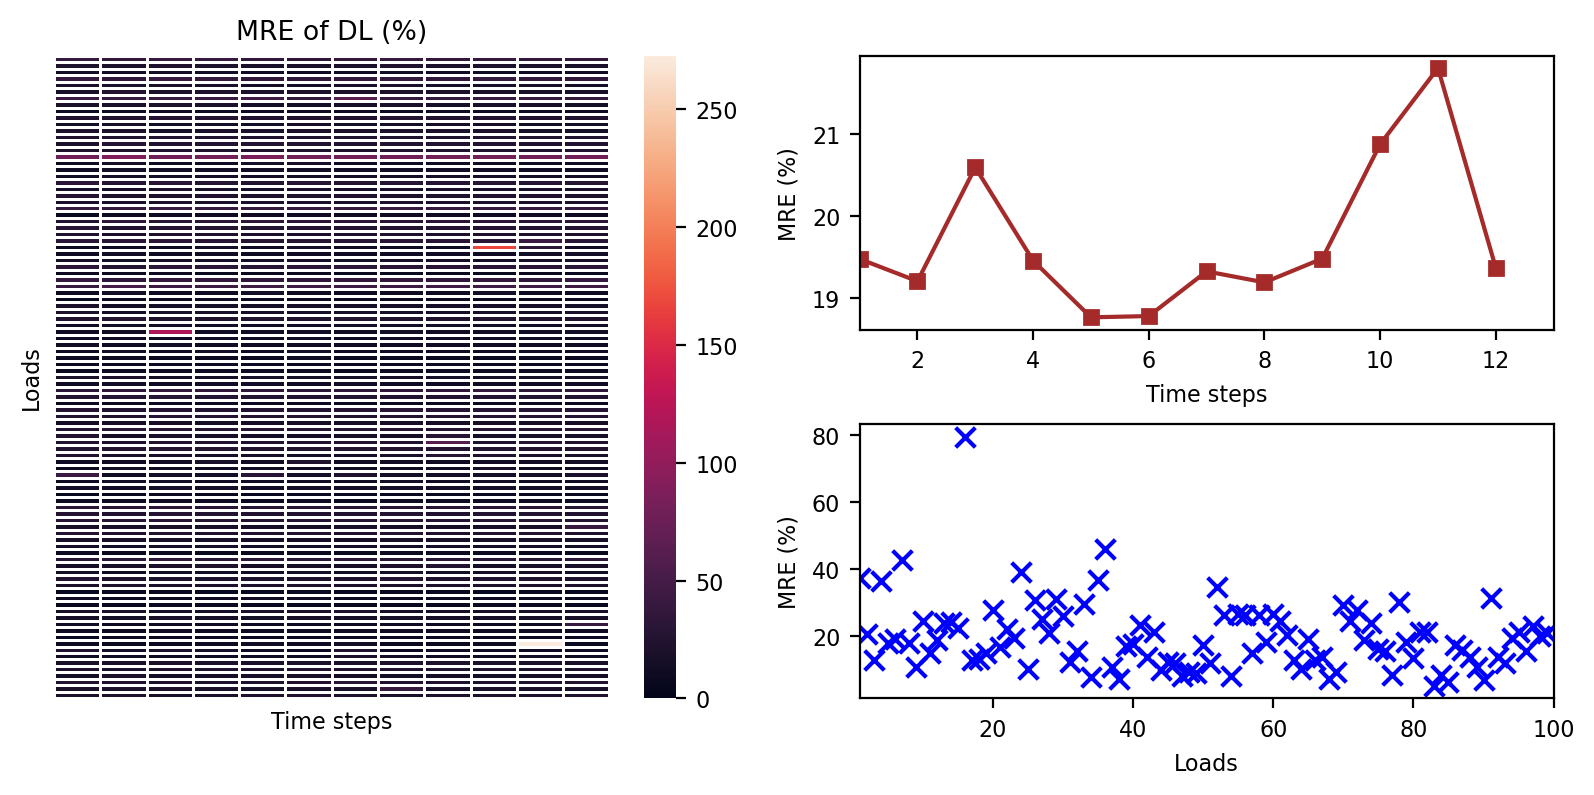

In [37]:
# Plot mean relative error
fig = plt.figure(figsize=(8, 4))
gs = GridSpec(2, 2)

ax = plt.subplot(gs[:, 0])
sns.heatmap(mre, 
            ax=ax,
            vmin=0,
            xticklabels=[],
            yticklabels=[],
            linewidth=0.5)
ax.set_title('MRE of DL (%)')
ax.set_xlabel('Time steps')
ax.set_ylabel('Loads')

x = np.arange(1, 13)
mre_avg = mre.mean(axis=0)
ax = plt.subplot(gs[0, 1])
ax.plot(x, mre_avg, marker='s', color='brown', markersize=5)
ax.set_xlim((1, 13))
ax.set_xlabel('Time steps')
ax.set_ylabel('MRE (%)')

x = np.arange(1, load_bidx.sum()+1)
mre_avg = mre.mean(axis=1)
ax = plt.subplot(gs[1, 1])
ax.scatter(x, mre_avg, marker='x', color='blue', s=50)
ax.set_xlim((1, load_bidx.sum()+1))
ax.set_xlabel('Loads')
ax.set_ylabel('MRE (%)')

plt.tight_layout()
plt.show()
plt.close('all')

#### Load shedding

In [38]:
# Root
root = '../../train_val_test_dataset/IEEE_Case118/DL-GCN'

# Load all data with empty input
dataset = MyDataset(root=root, data_list=[])

# Get train dataset
test_size = 200

test_dataset = dataset[-test_size:]

# Create train loader
############ Shuffle cannot be true for testing data ##############
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [39]:
# Load bidx in each zone
load_bidx_zone1 = np.isin(load_buses, zone1_buses).flatten()
load_bidx_zone2 = np.isin(load_buses, zone2_buses).flatten()
load_bidx_zone3 = np.isin(load_buses, zone3_buses).flatten()

In [40]:
# Get load inputs
load_input = np.zeros((num_data, num_zones+1, nt))

for i, loader in enumerate(test_loader):
    # Get load input of individual graph
    temp = loader.x.detach().numpy()[load_bidx, -nt:]
    load_input[i, 0] = temp[load_bidx_zone1].sum(axis=0)
    load_input[i, 1] = temp[load_bidx_zone2].sum(axis=0)
    load_input[i, 2] = temp[load_bidx_zone3].sum(axis=0)
    load_input[i, 3] = temp.sum(axis=0)

# Read DL ground truth and prediction
DL_true= np.zeros((num_data, num_zones+1, nt))
DL_pred = np.zeros((num_data, num_zones+1, nt))
for i in range(num_data):
    file_path = f'model_evaluation/GCN/DL_true/true_{i+1}.csv'
    temp = pd.read_csv(file_path, header=None, index_col=None).to_numpy()[load_bidx]
    # temp = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    DL_true[i, 0] = temp[load_bidx_zone1].sum(axis=0)
    DL_true[i, 1] = temp[load_bidx_zone2].sum(axis=0)
    DL_true[i, 2] = temp[load_bidx_zone3].sum(axis=0)
    DL_true[i, 3] = temp.sum(axis=0)

    file_path = f'model_evaluation/GCN/DL_pred/pred_{i+1}.csv'
    temp = pd.read_csv(file_path, header=None, index_col=None).to_numpy()[load_bidx]
    # temp = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    DL_pred[i, 0] = temp[load_bidx_zone1].sum(axis=0)
    DL_pred[i, 1] = temp[load_bidx_zone2].sum(axis=0)
    DL_pred[i, 2] = temp[load_bidx_zone3].sum(axis=0)
    DL_pred[i, 3] = temp.sum(axis=0)

In [41]:
# Calculate shedding
shedding_true = load_input - DL_true
shedding_pred = load_input - DL_pred

shedding_rela_err = np.zeros(shedding_true.shape)

# Set relative error = NaN for zero ground truth
indices = np.where(np.abs(shedding_true) <= 0)
shedding_rela_err[indices] = np.NaN

# Calculate relative error for nonzero ground truth
indices = np.where(np.abs(shedding_true) > 200)
shedding_rela_err[indices] = np.abs((shedding_true[indices] - shedding_pred[indices]) / shedding_true[indices]) * 100

# Calculate MRE of load shedding
shedding_mre = np.nanmean(shedding_rela_err, axis=0)

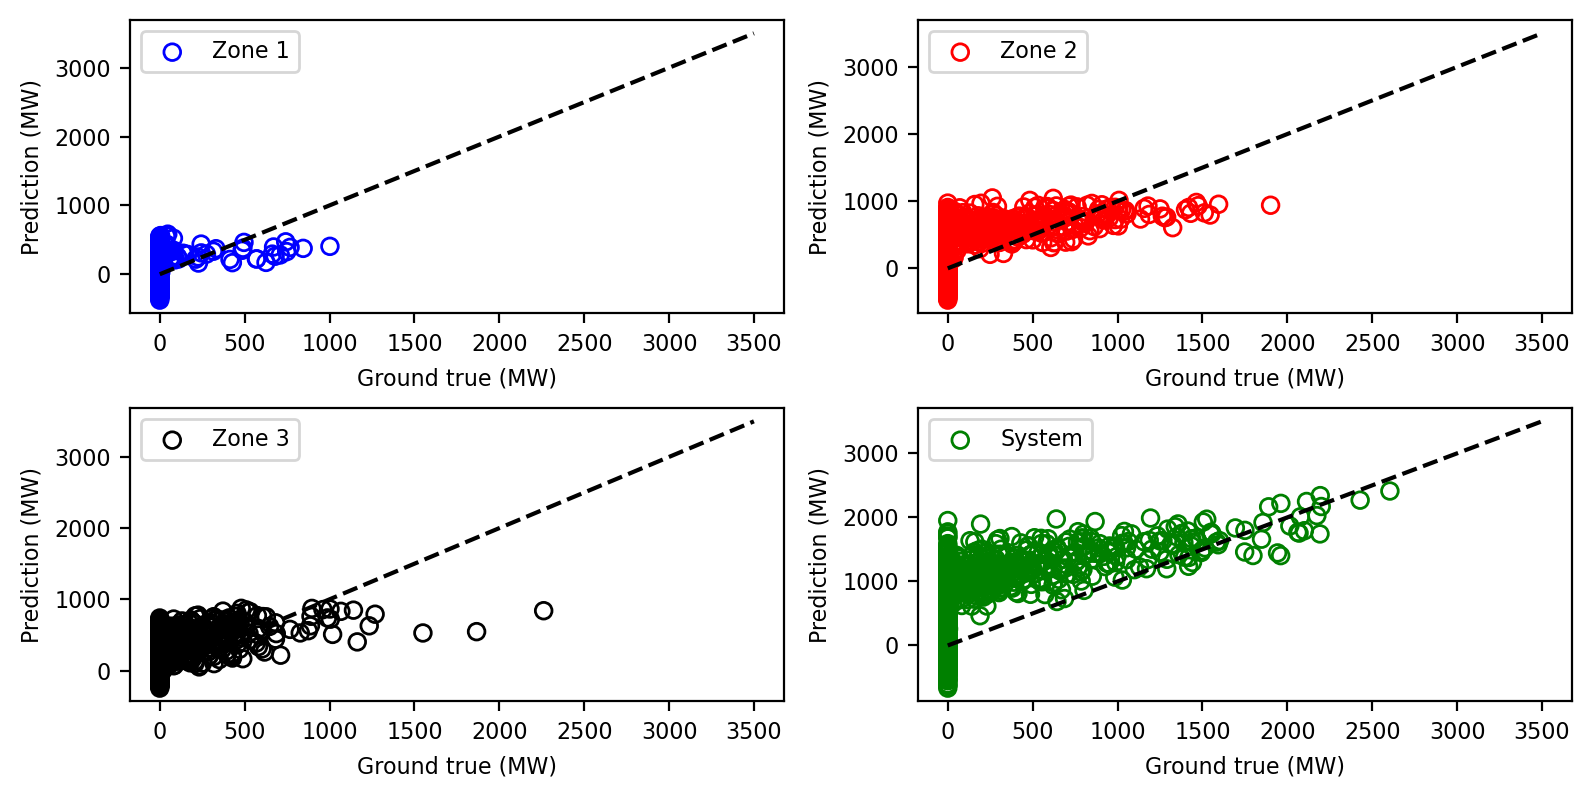

In [42]:
x = np.linspace(0, 3500, 100)
y = x

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(221)
ax1.plot(x, y, color='black', linestyle='dashed')
ax1.scatter(shedding_true[:, 0], shedding_pred[:, 0], marker='o', facecolors='none', edgecolors='blue', label='Zone 1')
ax1.set_xlabel('Ground true (MW)')
ax1.set_ylabel('Prediction (MW)')
ax1.legend()

ax2 = fig.add_subplot(222)
ax2.plot(x, y, color='black', linestyle='dashed')
ax2.scatter(shedding_true[:, 1], shedding_pred[:, 1], marker='o', facecolors='none', edgecolors='red', label='Zone 2')
ax2.set_xlabel('Ground true (MW)')
ax2.set_ylabel('Prediction (MW)')
ax2.legend()

ax3 = fig.add_subplot(223)
ax3.plot(x, y, color='black', linestyle='dashed')
ax3.scatter(shedding_true[:, 2], shedding_pred[:, 2], marker='o', facecolors='none', edgecolors='black', label='Zone 3')
ax3.set_xlabel('Ground true (MW)')
ax3.set_ylabel('Prediction (MW)')
ax3.legend()

ax4 = fig.add_subplot(224)
ax4.plot(x, y, color='black', linestyle='dashed')
ax4.scatter(shedding_true[:, 3], shedding_pred[:, 3], marker='o', facecolors='none', edgecolors='green', label='System')
ax4.set_xlabel('Ground true (MW)')
ax4.set_ylabel('Prediction (MW)')
ax4.legend()

plt.tight_layout()
plt.show()
plt.close('all')

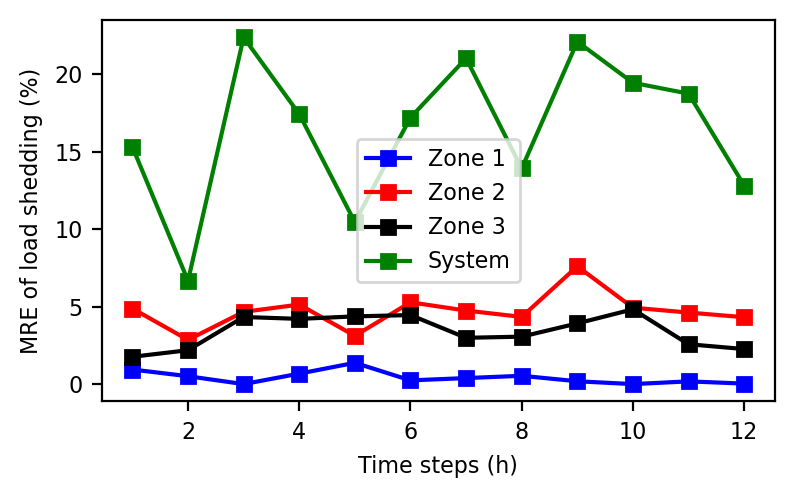

In [43]:
x = np.arange(1, 13)

fig = plt.figure(figsize=(4, 2.5))
ax = fig.add_subplot(111)
ax.plot(x, shedding_mre[0], color='blue', marker='s', markersize=5, label='Zone 1')
ax.plot(x, shedding_mre[1], color='red', marker='s', markersize=5, label='Zone 2')
ax.plot(x, shedding_mre[2], color='black', marker='s', markersize=5, label='Zone 3')
ax.plot(x, shedding_mre[3], color='green', marker='s', markersize=5, label='System')
ax.set_xlabel('Time steps (h)')
# ax.set_ylim((0, 40))
ax.set_ylabel('MRE of load shedding (%)')
ax.legend()

plt.tight_layout()
plt.show()
plt.close('all')

##### Save PF prediction

In [44]:
# Read PTDF matrix
file_path = f'../../data/IEEE_Case118/PTDF/PTDF_matrix.csv'
PTDF = pd.read_csv(file_path, header=None, index_col=None).to_numpy()

# Read wind input
# wind = np.zeros((num_data, num_buses, nt))
wind = np.zeros((num_data, num_buses, nt))
for i, loader in enumerate(test_loader):
    temp = loader.x.detach().numpy()[wind_bidx, -2*nt:-nt]
    wind[i, wind_bidx] = temp.copy()

for i in range(num_data):
    # Read PG true
    file_path = f'./model_evaluation/GCN/PG_true/true_{i+1}.csv'
    PG_true = pd.read_csv(file_path, index_col=None, header=None).to_numpy()
    # Read DL true
    file_path = f'./model_evaluation/GCN/DL_true/true_{i+1}.csv'
    DL_true = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    # DL_true = np.zeros((num_buses, nt))
    # DL_true[load_bidx] = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    PB_true = wind[i] + PG_true - DL_true
    PF_true = np.round(PTDF@PB_true, 2)
    file_path = f'model_evaluation/GCN/PF_true/true_{i+1}.csv'
    pd.DataFrame(PF_true).to_csv(file_path, columns=None, index=None, header=None)

    # Read PG prediction
    file_path = f'./model_evaluation/GCN/PG_pred/pred_{i+1}.csv'
    PG_pred = pd.read_csv(file_path, index_col=None, header=None).to_numpy()
    # Read DL prediction
    file_path = f'./model_evaluation/GCN/DL_pred/pred_{i+1}.csv'
    DL_pred = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    # DL_pred = np.zeros((num_buses, nt))
    # DL_pred[load_bidx] = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    PB_pred = wind[i] + PG_pred - DL_pred
    PF_pred = np.round(PTDF@PB_pred, 2)
    file_path = f'model_evaluation/GCN/PF_pred/pred_{i+1}.csv'
    pd.DataFrame(PF_pred).to_csv(file_path, columns=None, index=None, header=None)